In [3]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
import tensorflow as tf

In [4]:
mypath = "/kaggle/input/seismic-data/data/train/moon"
csv_files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]

In [5]:
catalog_df = pd.read_csv("/kaggle/input/seismic-detection-across-the-solar-system/data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv")

In [6]:
time_steps = 500  # Set your preferred time window length

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization

# CNN-based model for time-series classification
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 2)))  # 2 is the number of features
model.add(BatchNormalization())  # Helps with convergence
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten and add a dense layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))  # Fully connected layer after convolutions
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # Output layer for binary classification

# model = load_model("/kaggle/input/scismic-model-cnn/tensorflow2/default/1/quake_detector_model(proximity)-CNN.h5")
# Compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), 
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def proximity_list(length, certain_index):
    proximity = [0] * length  # Initialize list with zeros
    max_distance = max(certain_index, length - 1 - certain_index)  # Max distance from certain_index to the start/end
    for i in range(length):
        # Calculate distance from the certain index
        distance = abs(i - certain_index)
        # Normalize the value so it peaks at 1 at the certain index and decreases symmetrically
        proximity[i] = 1 - (distance / max_distance) 
    return proximity

In [8]:
def process_file_in_batch(csv_file, model, index):
    # Load a single CSV file
    df = pd.read_csv(csv_file)
        
    df['proximity'] = proximity_list(len(df.index), catalog_df['time_rel(sec)'].iloc[index])
    
    # Include the new features along with time_rel and velocity
    X = df[['proximity','velocity']].values
    y = df['mq'].values
    
    
    # Reshape X for LSTM (samples, time_steps, features)
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps - 1])
        
        
    # Convert to NumPy arrays for model training
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    
    
    # Train the model incrementally or append the processed data for batch processing
    model.fit(X_seq, y_seq)
    model.save('quake_detector_model(proximity)-CNN.h5')

In [38]:
# Process files one by one
c = 0
for csv_file in csv_files[0:1]:
    print(c)
    process_file_in_batch(csv_file, model, c)
    c += 1 

0
17873/17873 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9875 - loss: 0.2297
68
17873/17873 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.9823 - loss: 0.2386


In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/scismic-model-cnn/tensorflow2/default/1/quake_detector_model(proximity)-CNN.h5')

In [10]:
%%capture
! pip install obspy

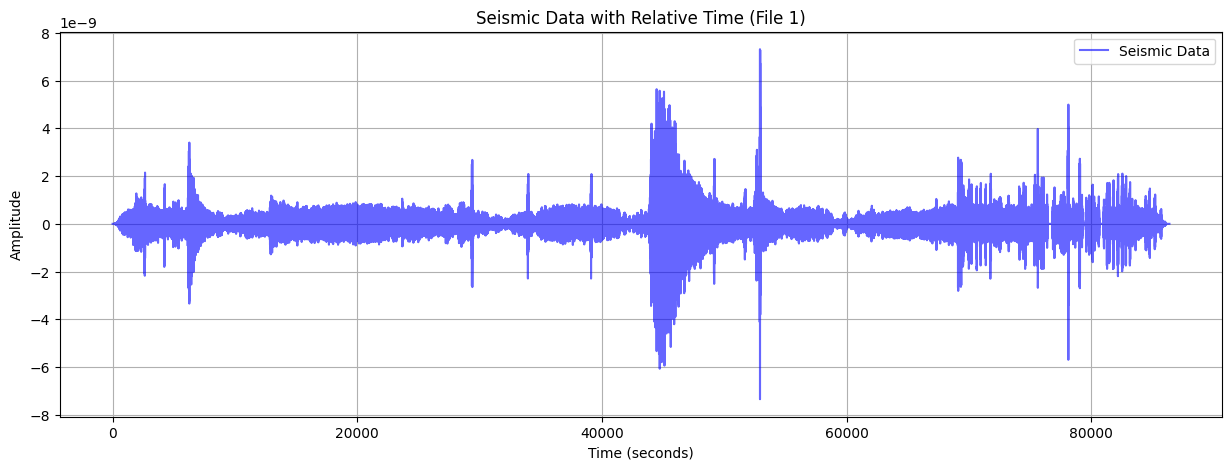

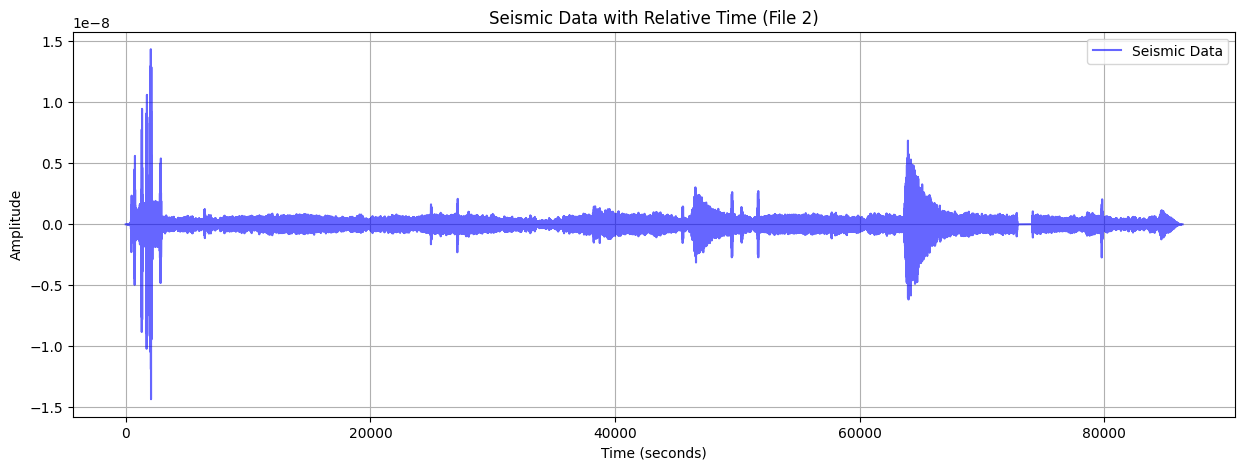

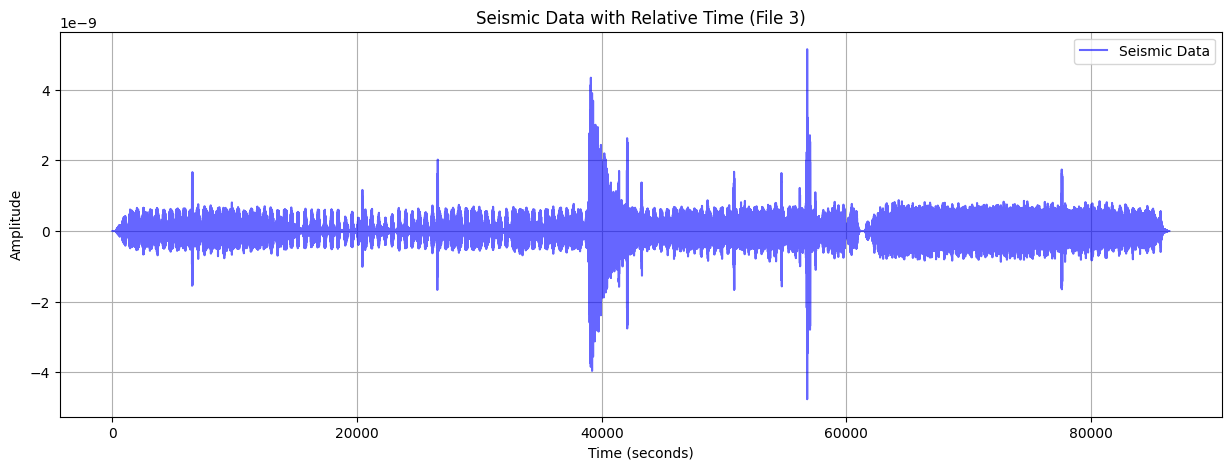

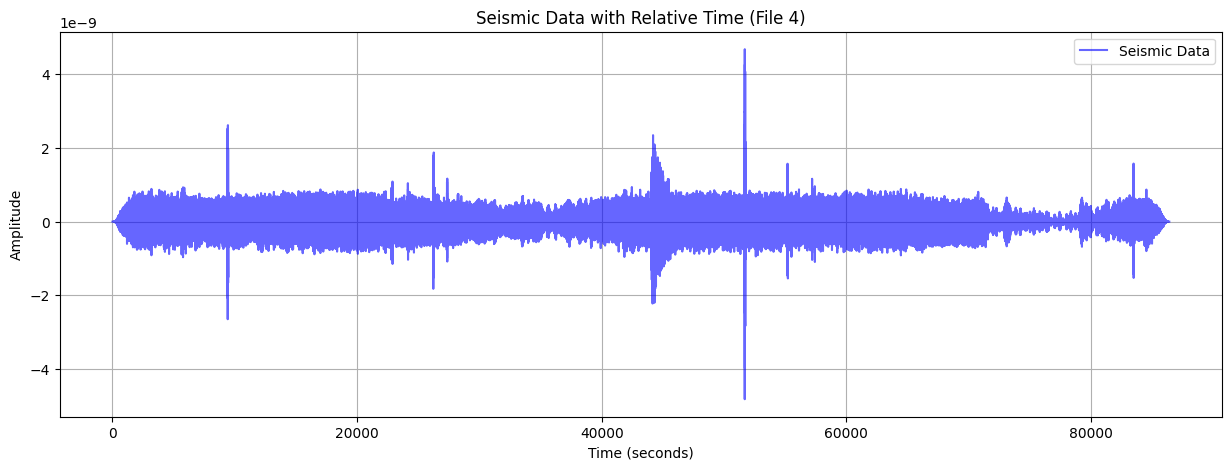

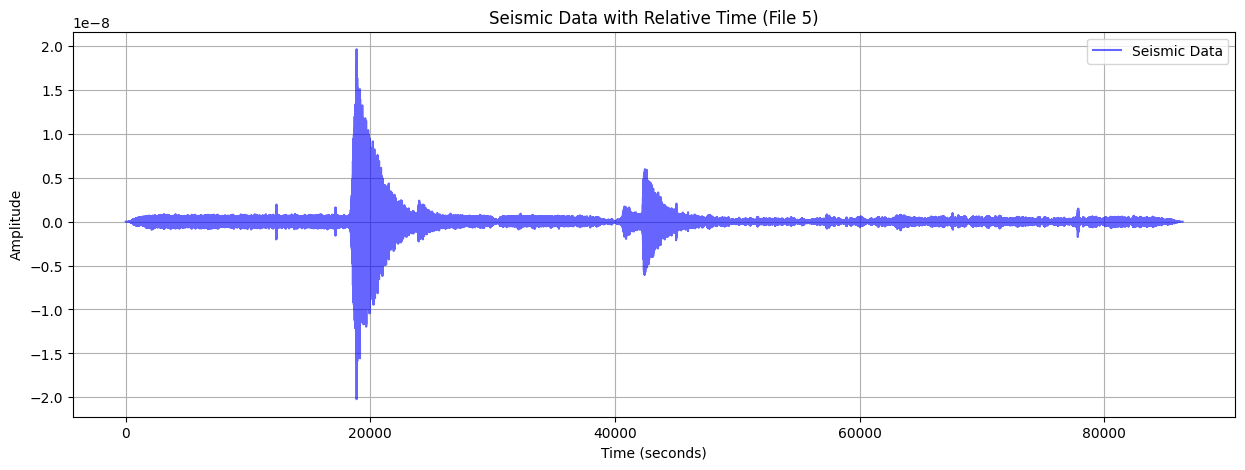

In [11]:
import obspy
import matplotlib.pyplot as plt
import numpy as np

# List of MiniSEED files
mseed_files = [
    '/kaggle/input/seismic-detection-across-the-solar-system/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed',
    '/kaggle/input/seismic-detection-across-the-solar-system/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed',
    '/kaggle/input/seismic-detection-across-the-solar-system/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-04-03HR00_evid00021.mseed',
    '/kaggle/input/seismic-detection-across-the-solar-system/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-25HR00_evid00029.mseed',
    '/kaggle/input/seismic-detection-across-the-solar-system/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-20HR00_evid00037.mseed'
]

# Loop through each MiniSEED file and create a separate plot for each
for i, file_path in enumerate(mseed_files):
    # Load the mseed file
    stream = obspy.read(file_path)

    # Extract the trace from the stream (assuming there's one trace in the file)
    trace = stream[0]

    # Get the data and sampling rate
    data = trace.data
    sampling_rate = trace.stats.sampling_rate

    # Calculate relative time in seconds using np.linspace to ensure same length
    n_samples = len(data)
    time_rel = np.linspace(0, n_samples / sampling_rate, n_samples)

    # Create a new plot for the current file
    plt.figure(figsize=(15, 5))

    # Plot the data with relative time
    plt.plot(time_rel, data, label='Seismic Data', color='blue', alpha=0.6)

    # Plot styling
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Seismic Data with Relative Time (File {i+1})')
    plt.legend()
    plt.grid(True)

    # Show plot for the current file
    plt.show()

I0000 00:00:1728304270.866617      99 service.cc:145] XLA service 0x7a5edc007920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728304270.866665      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728304270.866669      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  113/17873 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step 

I0000 00:00:1728304272.703336      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17873/17873 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
Relative times of the 10 closest predictions to the threshold (0.1):
Prediction 1: 44389.89 seconds
Prediction 2: 44390.94 seconds
Prediction 3: 44355.02 seconds
Prediction 4: 44349.28 seconds
Prediction 5: 44351.70 seconds


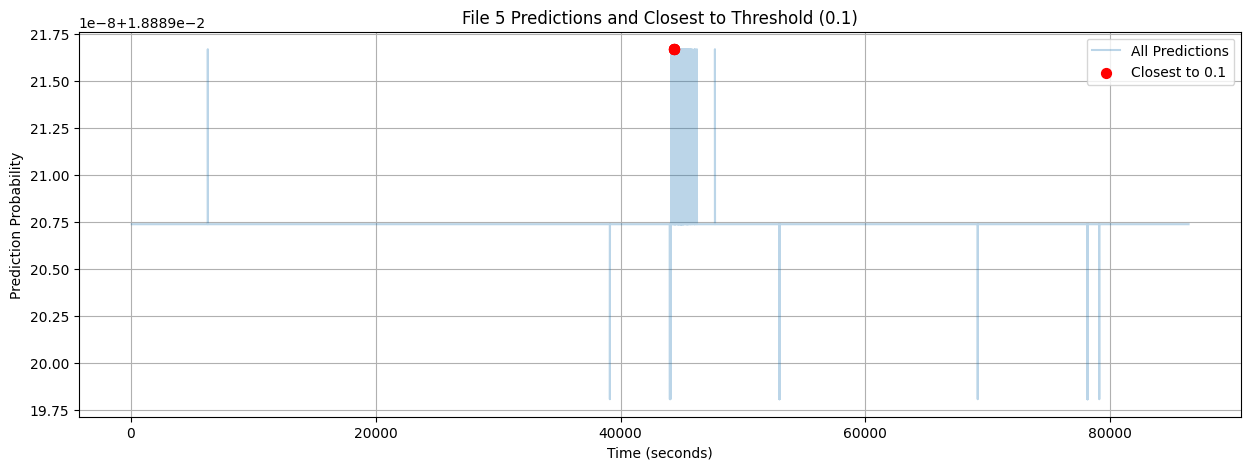

17871/17871 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
Relative times of the 10 closest predictions to the threshold (0.1):
Prediction 1: 63909.13 seconds
Prediction 2: 63909.43 seconds
Prediction 3: 63888.30 seconds
Prediction 4: 63883.02 seconds
Prediction 5: 63857.66 seconds


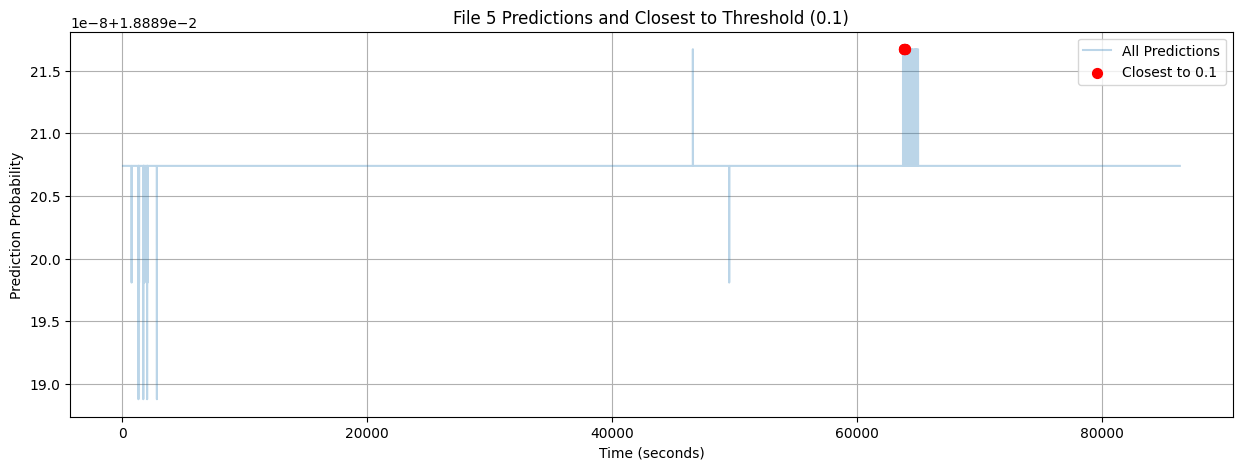

17873/17873 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
Relative times of the 10 closest predictions to the threshold (0.1):
Prediction 1: 39639.09 seconds
Prediction 2: 39277.28 seconds
Prediction 3: 39241.21 seconds
Prediction 4: 39110.49 seconds
Prediction 5: 39060.23 seconds


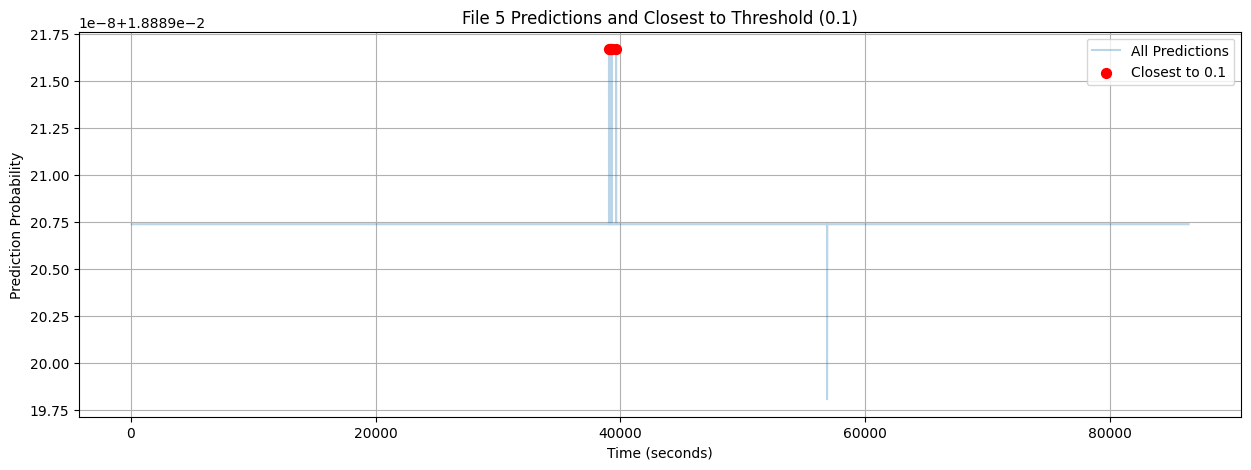

17873/17873 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
Relative times of the 10 closest predictions to the threshold (0.1):
Prediction 1: 86401.51 seconds
Prediction 2: 86401.36 seconds
Prediction 3: 86401.21 seconds
Prediction 4: 44292.38 seconds
Prediction 5: 86401.06 seconds


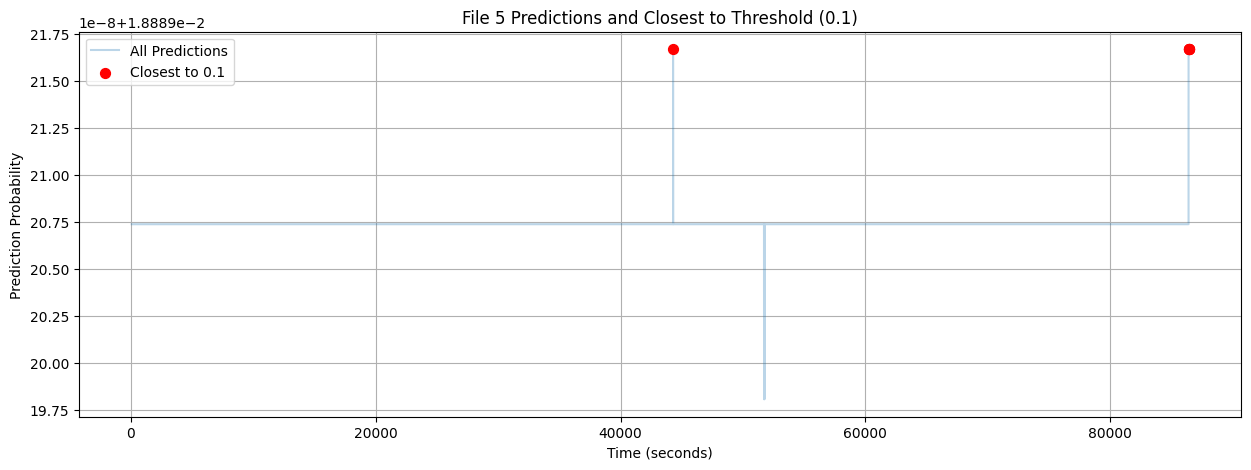

17873/17873 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
Relative times of the 10 closest predictions to the threshold (0.1):
Prediction 1: 19614.19 seconds
Prediction 2: 19625.36 seconds
Prediction 3: 19625.96 seconds
Prediction 4: 19633.81 seconds
Prediction 5: 19639.85 seconds


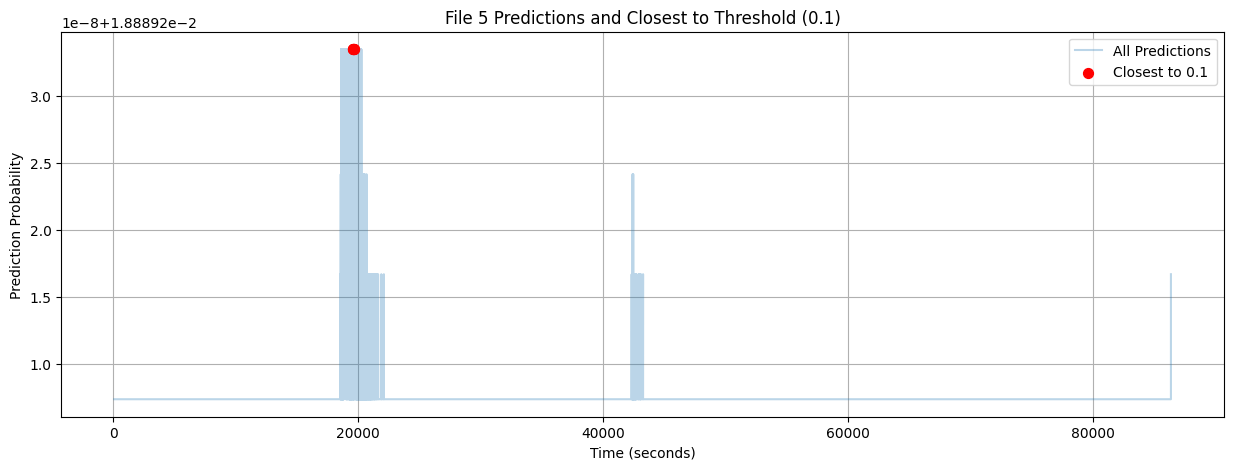

In [12]:
# List of test files
test_files = [
    "/kaggle/input/seismic-data/data/test/moon/12_b_00016.csv",
    "/kaggle/input/seismic-data/data/test/moon/12_b_00020.csv",
    "/kaggle/input/seismic-data/data/test/moon/12_b_00021.csv",
    "/kaggle/input/seismic-data/data/test/moon/12_b_00029.csv",
    "/kaggle/input/seismic-data/data/test/moon/12_b_00037.csv"

]

# Loop through each test file and create a separate plot for each
for i, test_file in enumerate(test_files):
    # Load test data
    test_df = pd.read_csv(test_file)
    
    test_df['proximity'] = [0] * len(test_df.index)

    # Prepare the test data similar to how you prepared the training data
    test_X = test_df[['proximity', 'velocity']].values

    # Reshape X for CNN (samples, time_steps, features)
    time_steps = 500  # Adjust according to your model's time step requirement
    X_test = []
    for j in range(len(test_X) - time_steps):
        X_test.append(test_X[j:j + time_steps])

    X_test = np.array(X_test)

    # Make predictions
    predictions = model.predict(X_test)
    predictions_flat = predictions.flatten()

    # Find indices of predictions closest to 0.1
    threshold = 0.1
    absolute_differences = np.abs(predictions_flat - threshold)
    closest_indices = np.argsort(absolute_differences)[:5]  # Get the 5 closest
    
    # Extract relative times for closest predictions
    closest_times = test_df['time_rel'][closest_indices + time_steps].values

    # Print the relative times
    print("Relative times of the 10 closest predictions to the threshold (0.1):")
    for i, time in enumerate(closest_times):
        print(f"Prediction {i+1}: {time:.2f} seconds")

    # Create a new plot for the current file
    plt.figure(figsize=(15, 5))

    # Plot all predictions for this file
    plt.plot(test_df['time_rel'][time_steps:], predictions_flat, label='All Predictions', alpha=0.3)

    # Plot closest predictions for this file
    plt.scatter(test_df['time_rel'][closest_indices + time_steps], predictions_flat[closest_indices], 
                color='red', label='Closest to 0.1', zorder=5, s=50)

    # Plot styling
    plt.xlabel('Time (seconds)')
    plt.ylabel('Prediction Probability')
    plt.title(f'File {i+1} Predictions and Closest to Threshold (0.1)')
    plt.legend()
    plt.grid(True)

    # Show plot for the current file
    plt.show()
